In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
col_names = [
    "poisonous?",
    
    "cap-shape",
    "cap-surface",
    "cap-color",
    
    "bruises?",
    "odor",
    
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    
    "stalk-shape",
    "stalk-root",
    
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    
    "veil-type",
    "veil-color",
    
    "ring-number",
    "ring-type",
    
    "spore-print-color",
    
    "population",
    
    "habitat"
]
df = pd.read_csv("Data/agaricus-lepiota.csv", names=col_names)
# header=None is redundant in read_csv, see read_csv documentation
display(df)

,poisonous?,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


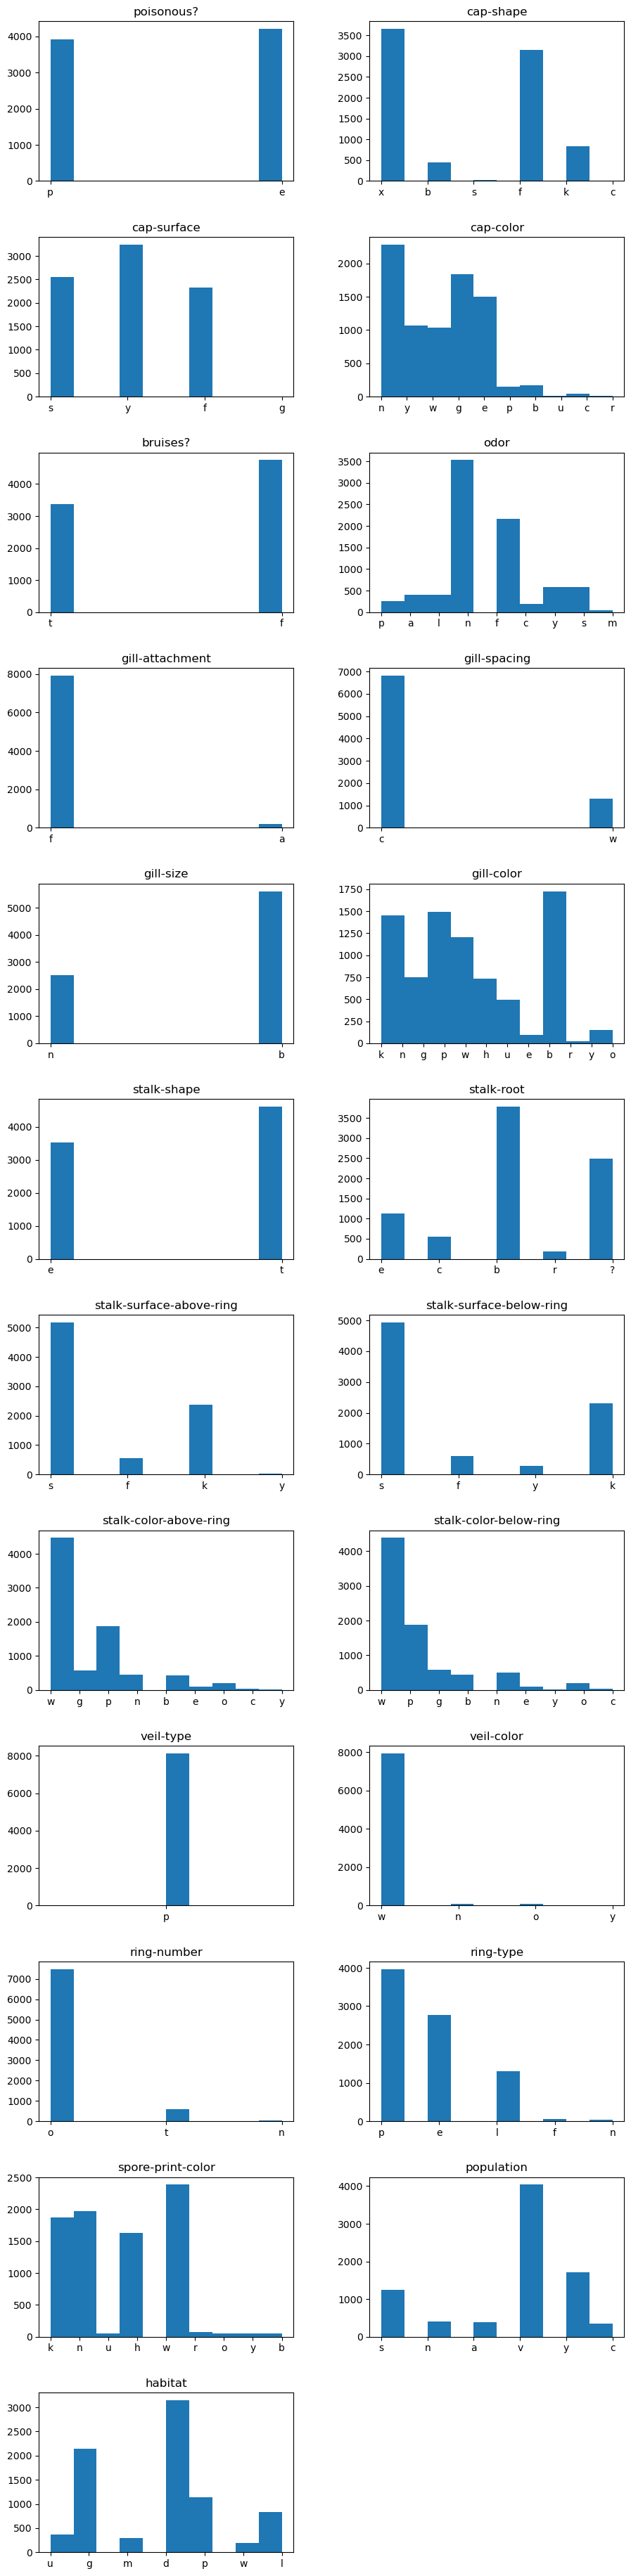

In [3]:
# We run histograms on all the features, to get an idea of value distributions
# and to discover potential patterns

for index, feature in enumerate(col_names):
    index += 1
    if(index <= len(col_names)):
        plt.subplot(12, 2, index)
        plt.hist(df.loc[:, feature])
        plt.title(feature)

plt.subplots_adjust(left=0.0,
                    bottom=0.0,
                    right=1.3,
                    top=7.5,
                    wspace=0.3,
                    hspace=0.35)
plt.show()

In [4]:
# We now make some initial obvious data discoveries

# bruises feature does not necessarily have much to do with
# the mushroom itself, but is a result of handling, therefore
# it is unlikely we'll get much real information from this feature

In [5]:
# stalk-root feature has a large proportion of missing values,
# which indicates we may likely have to drop the feature
df["stalk-root"].value_counts()

b    3776
?    2480
e    1120
c     556
r     192
Name: stalk-root, dtype: int64

In [6]:
# veil-type feature has just a single type of value, and because
# of this there is no information contained in this feature
df["veil-type"].value_counts()

p    8124
Name: veil-type, dtype: int64

In [7]:
# Now we look for dependencies across the features, we suspect
# that gill-attachment and gill-spacing at least partially
# determine each other, and so we check it out

ga = "gill-attachment"
gs = "gill-spacing"
ga_gs = df[[ga, gs]]

total = df.shape[0]
ga_gs_pairs = {"f-c": 0, "f-w": 0, "a-c": 0, "a-w": 0}
for i in range(total):
    row = ga_gs.iloc[i]
    r_ga = row["gill-attachment"]
    r_gs = row["gill-spacing"]
    ga_gs_pairs[r_ga + "-" + r_gs] += 1

print("Absolute Number of Pairs:\n" + str(ga_gs_pairs))

rel_ga_gs_pairs = ga_gs_pairs.copy()
for key, val in ga_gs_pairs.items():
    if (val != 0):
        rel_ga_gs_pairs[key] = val / total
    
print("Relative Number of Pairs:\n" + str(rel_ga_gs_pairs))

# we can see from results that if gill-spacing has value "w",h
# then there's a 100% chance the gill-attachment value is "f",
# and correspondingly, if gill-attachment is value "a", then
# there's 100% chance the value in gill-spacing is "c"

Absolute Number of Pairs:
{'f-c': 6602, 'f-w': 1312, 'a-c': 210, 'a-w': 0}
Relative Number of Pairs:
{'f-c': 0.8126538650910882, 'f-w': 0.16149679960610536, 'a-c': 0.0258493353028065, 'a-w': 0}


In [8]:
# From the data investigation of the feature above
# we can determine that this will have no differentiating
# impact on any ML algorithm, and will not function as
# valuable data in making a model

<AxesSubplot:>

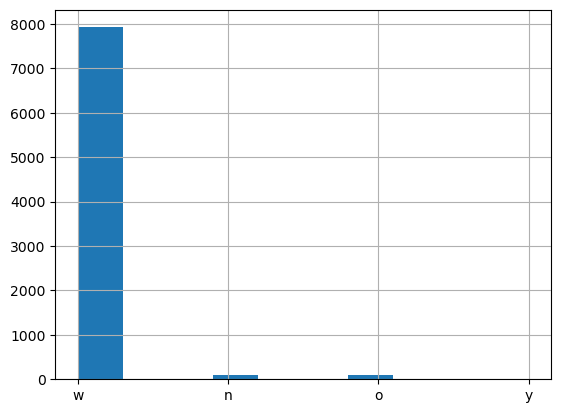

In [9]:
pd_series2 = df.loc[:, "veil-color"]
pd_series2.hist()